In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm


In [2]:
# Part A test dataset paths
IMG_DIR_A = "./processed/test/images"
DEN_DIR_A = "./processed/test/density"

# Part A trained model
MODEL_PATH_A = "./csrnet_final.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
import torch.nn as nn

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        self.frontend = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True)
        )

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, dilation=2, padding=2), nn.ReLU(inplace=True)
        )

        self.output = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output(x)
        return x


In [4]:
modelA = CSRNet().to(device)
modelA.load_state_dict(torch.load(MODEL_PATH_A, map_location=device))
modelA.eval()

print("Part A model loaded successfully.")


Part A model loaded successfully.


In [5]:
mae, mse = 0.0, 0.0
times = []

files = sorted(os.listdir(IMG_DIR_A))

with torch.no_grad():
    for fname in tqdm(files):
        img = np.load(os.path.join(IMG_DIR_A, fname))
        gt = np.load(os.path.join(DEN_DIR_A, fname))

        img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float().to(device)

        start = time.time()
        pred = modelA(img)
        times.append(time.time() - start)

        pred_count = pred.sum().item()
        gt_count = gt.sum()

        mae += abs(pred_count - gt_count)
        mse += (pred_count - gt_count) ** 2

mae /= len(files)
rmse = (mse / len(files)) ** 0.5

print(f"Part A Results → MAE: {mae:.2f}, RMSE: {rmse:.2f}")
print(f"Average inference time: {np.mean(times):.4f} seconds")


100%|██████████| 182/182 [09:44<00:00,  3.21s/it]


Part A Results → MAE: 95.53, RMSE: 153.21
Average inference time: 2.4490 seconds


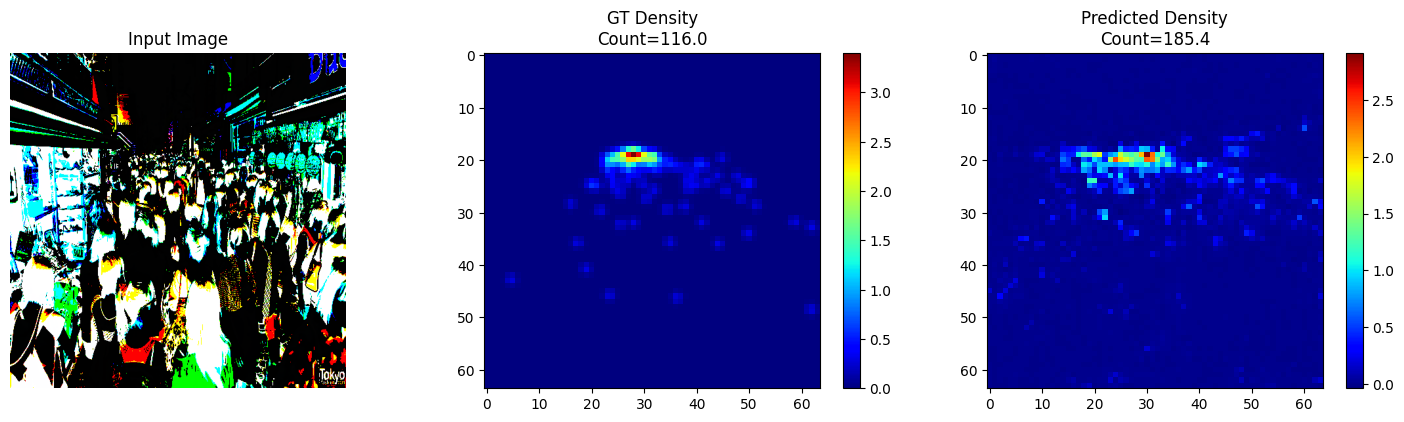

In [6]:
idx = np.random.randint(len(files))
fname = files[idx]

img = np.load(os.path.join(IMG_DIR_A, fname))
gt = np.load(os.path.join(DEN_DIR_A, fname))

with torch.no_grad():
    inp = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)
    pred = modelA(inp).cpu().squeeze().numpy()

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.imshow(img.astype(np.uint8))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="jet")
plt.title(f"GT Density\nCount={gt.sum():.1f}")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(pred, cmap="jet")
plt.title(f"Predicted Density\nCount={pred.sum():.1f}")
plt.colorbar()

plt.tight_layout()
plt.show()


In [7]:
IMG_DIR_B = "./processedB/test/images"
DEN_DIR_B = "./processedB/test/density"

MODEL_PATH_B = "./csrnet_finalB.pth"


In [8]:
modelB = CSRNet().to(device)
modelB.load_state_dict(torch.load(MODEL_PATH_B, map_location=device))
modelB.eval()

print("Part B model loaded successfully.")


Part B model loaded successfully.


In [9]:
mae, mse = 0.0, 0.0
times = []

files = sorted(os.listdir(IMG_DIR_B))

with torch.no_grad():
    for fname in tqdm(files):
        img = np.load(os.path.join(IMG_DIR_B, fname))
        gt = np.load(os.path.join(DEN_DIR_B, fname))

        img = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)

        start = time.time()
        pred = modelB(img)
        times.append(time.time() - start)

        pred_count = pred.sum().item()
        gt_count = gt.sum()

        mae += abs(pred_count - gt_count)
        mse += (pred_count - gt_count) ** 2

mae /= len(files)
rmse = (mse / len(files)) ** 0.5

print(f"Part B Results → MAE: {mae:.2f}, RMSE: {rmse:.2f}")
print(f"Average inference time: {np.mean(times):.4f} seconds")


100%|██████████| 316/316 [16:52<00:00,  3.20s/it]

Part B Results → MAE: 13.53, RMSE: 25.02
Average inference time: 2.6105 seconds


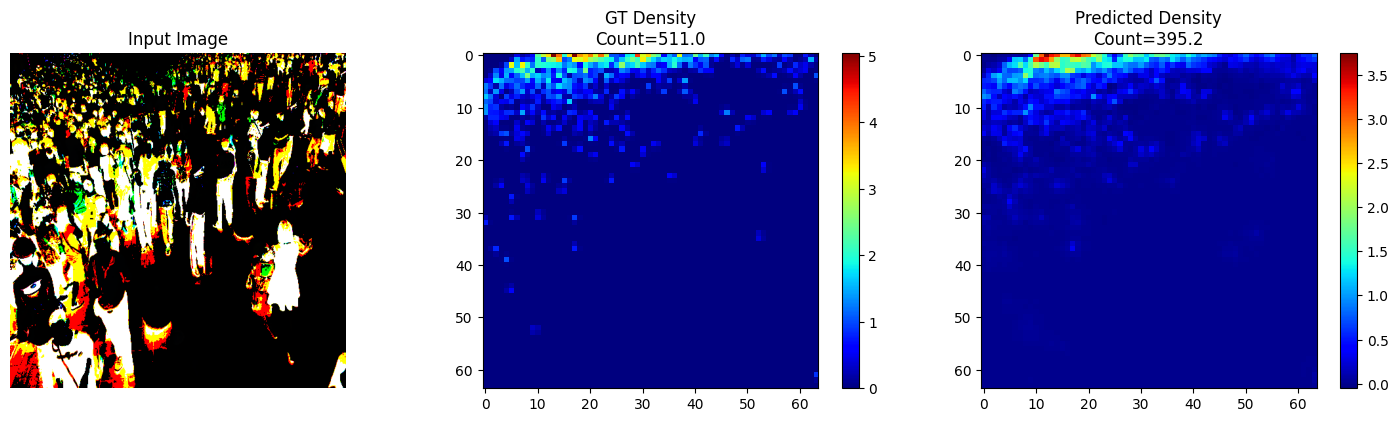

In [10]:
idx = np.random.randint(len(files))
fname = files[idx]

img = np.load(os.path.join(IMG_DIR_B, fname))
gt = np.load(os.path.join(DEN_DIR_B, fname))

with torch.no_grad():
    inp = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)
    pred = modelB(inp).cpu().squeeze().numpy()

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.imshow(img.astype(np.uint8))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="jet")
plt.title(f"GT Density\nCount={gt.sum():.1f}")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(pred, cmap="jet")
plt.title(f"Predicted Density\nCount={pred.sum():.1f}")
plt.colorbar()

plt.tight_layout()
plt.show()
